In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pytorch_lightning as pl
import soundfile as sf
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display
from scipy.fftpack import fft, dct

from argparse import Namespace
from tqdm.notebook import tqdm

print(torch.cuda.is_available())
device = 'cuda'
device = 'cpu'

True


In [62]:
audio_file = '../data/piano.wav'
# x, fs = sf.read('../data/piano.wav')
x, fs = lb.load(audio_file, sr=8000)
x = x[:,None]
print(x.shape)
print(fs)

(98430, 1)
8000


(98430, 1)


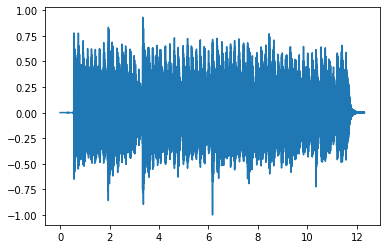

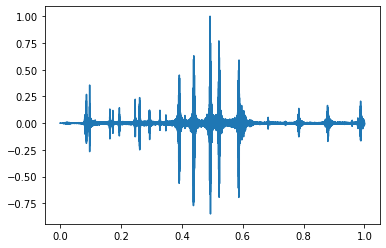

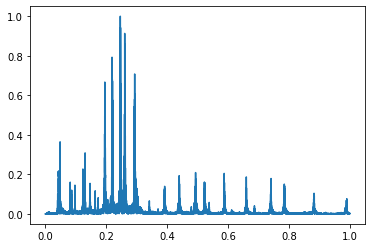

In [63]:
# to mono
x = x - np.mean(x, axis=0)

dur = 14

x = x[int(0*fs):int((dur)*fs)]
x = x / np.max(np.abs(x))
t = np.arange(0,len(x))/fs
t = t[:,None]
print(x.shape)

plt.plot(t, x)
plt.show()


Xs = dct(x, axis=0)[:len(x)//4]
Xs = Xs/np.max(np.abs(Xs))
s = np.linspace(0,1,len(Xs))
plt.plot(s, Xs)
plt.show()


Xf = fft(x, axis=0)[:len(x)//4]
Xf = Xf/np.max(np.abs(Xf))
f = np.linspace(0,1,len(Xf))
plt.plot(f, np.abs(Xf))
plt.show()



s = torch.from_numpy(x).float()
t = torch.from_numpy(t).float()
S = torch.from_numpy(X).float()
f = torch.from_numpy(f).float()

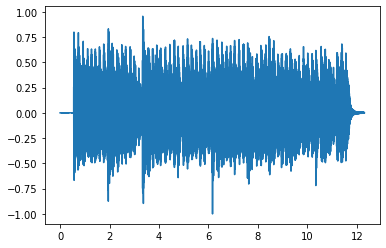

In [45]:
class CurrDataset(torch.utils.data.Dataset):

    def __init__(self, t, x):
        super(CurrDataset, self).__init__()

        self.x = x
        self.t = t
        assert x.shape == t.shape
        self.size = x.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        t = self.t[idx,:]
        x = self.x[idx,:]
        return t, x

dataset = CurrDataset(t, s)
invar, outvar = dataset[:]

plt.plot(invar, outvar)
plt.show()

In [60]:
import torch.nn as nn

class ImplicitFourierFilter(nn.Module):
    def __init__(self, in_dim, out_dim, alpha, beta=2.0, bias=True, max_freq=128.):
        super(ImplicitFourierFilter, self).__init__()

        self.gamma = nn.Parameter(torch.distributions.gamma.Gamma(alpha, beta).sample((out_dim, )))
        self.linear = torch.nn.Linear(in_dim, out_dim, bias=bias)
        
        self.max_freq = max_freq

        # Init weights
        self.linear.weight.data *= max_freq * torch.sqrt(self.gamma.unsqueeze(-1))
        if bias:
            self.linear.bias.data.uniform_(-np.pi, np.pi)
        
#         B = torch.linspace(0, max_freq, 1024)[:,None]
#         self.B = nn.Parameter(B, requires_grad=False)
        
        
    def forward(self, x):
        ''' x in B x 1
            z in F x 1
        '''
        x = self.linear(x)
        return torch.sin(x)


class iMFN(nn.Module):
    def __init__(self):
        super(iMFN, self).__init__()

        K = 2
        
        # freqs to weights
        hidden_dim = 1024
        max_freq = 1e3
        self.fft = nn.Sequential(
            ImplicitFourierFilter(1, hidden_dim, alpha=6.0 / K, max_freq=max_freq, bias=True),
            torch.nn.Linear(hidden_dim, 1, bias=False),
        )
        
        # time to signal
        hidden_dim = 1024
        max_freq = 8e3 # 22e3

        self.time = nn.Sequential(
            ImplicitFourierFilter(1, hidden_dim, alpha=6.0 / K, max_freq=max_freq, bias=False),
            torch.nn.Linear(hidden_dim, 1, bias=False),
        )
        self.time[1].weight.data.uniform_(-np.sqrt(1.0 / hidden_dim), np.sqrt(1.0 / hidden_dim))


    def forward(self, t, ftest=None, stage='train_time'):
        
        if stage == 'train_freq':
            self.fft.requires_grad_(True)
            self.time.requires_grad_(False)
        elif stage == 'train_time':
            self.fft.requires_grad_(True)
            self.time.requires_grad_(True)
       
        f = self.time[0].linear.weight.data # target freqs
        w = self.time[1].weight.data # target weights
        wn = self.fft(f)

        if stage in ['train_time', 'train_freq']:
            x = self.time(t) # B x out
        
        if stage == 'test':
            wn = self.fft(ftest)
            self.time[0].linear.weight.data = ftest
            self.time[1].weight.data = wn.T
            x = self.time(t)
            
        return x, w, wn

In [61]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=267, shuffle=True)
# model = MFN(in_dim=1, hidden_dim=1024, out_dim=1, k=1, filter_fun='Fourier', data_max_freq=10e3)
model = iMFN()
print(model)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


#initialize empty list to track batch losses
batch_losses = []

#train the neural network for 5 epochs
for epoch in tqdm(range(1000)):

    #reset iterator
    batch = iter(dataloader)
    
    for invar, outvar in batch:
                
        #forward propagation through the network
        
        #reset gradients
        optimizer.zero_grad()

        if epoch < 300:
            outvar_pred = model(invar, 'train_time')[0]

            #calculate the loss
            loss = torch.mean(torch.abs(outvar_pred - outvar)**2)
            
        if epoch >= 300:
            outvar_pred, w, f, wn, fn = model(invar, 'train_freq')
            #calculate the loss
            loss_w = torch.mean(torch.abs(w - wn)**2)
            loss_f = torch.mean(torch.abs(f - fn)**2)
            loss = loss_w + loss_f

        #track batch loss
        batch_losses.append(loss.item())

        #backpropagation
        loss.backward()

        #update the parameters
        optimizer.step()
    
    if epoch % 20 == 0:
        scheduler.step()
        
        
    if epoch % 100 == 0:
        print(batch_losses[-1])
#         plt.plot(batch_losses)
#         plt.show()

torch.save(model.state_dict(), './model.ptc')

iMFN(
  (fft): Sequential(
    (0): ImplicitFourierFilter(
      (linear): Linear(in_features=1, out_features=1024, bias=True)
    )
    (1): Linear(in_features=1024, out_features=1, bias=False)
  )
  (time): Sequential(
    (0): ImplicitFourierFilter(
      (linear): Linear(in_features=1, out_features=1024, bias=False)
    )
    (1): Linear(in_features=1024, out_features=1, bias=False)
  )
)


  0%|          | 0/1000 [00:00<?, ?it/s]

0.04516083374619484


KeyboardInterrupt: 

In [ ]:
model.lin_t1.bias

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('./model.ptc'))
print(model)

invar, outvar = dataset[:]

outvar_pred = model(invar, stage='train_time')[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar)
plt.plot(invar.detach(), outvar_pred[:,0].detach())


freqs = model.flt_t1.linear.weight.data
print(freqs.shape)
outvar_pred = model(invar, ftest=freqs, stage='test')[0]

plt.plot(invar.detach(), outvar_pred[:,0].detach(), alpha=0.5)
plt.show()

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('./model.ptc'))
print(model)

invar, outvar = dataset[:]

outvar_pred = model(invar, stage='train_time')[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar)
plt.plot(invar.detach(), outvar_pred[:,0].detach())

freqs = model.flt_t1.linear.weight.data
freqs = freqs[::1]
idx = torch.argsort(freqs, dim=0).squeeze()
freqs = freqs[idx,:]
freqs = freqs[512-512:512+512] # low pass
# freqs = torch.linspace(freqs.min(), freqs.max(), 1024)[:,None]
outvar_pred = model(invar, ftest=freqs, stage='test')[0]

plt.plot(invar.detach(), outvar_pred[:,0].detach())
plt.show()

In [ ]:
w = model.lin_t1.weight.data
f = model.flt_t1.linear.weight.data
c = model.lin_f1(model.flt_f1(f)).data

idx = torch.argsort(f, dim=0)
f = f.squeeze()[idx]
w = w.squeeze()[idx]
c = c.squeeze()[idx]

plt.plot(f)
plt.show()
plt.plot(f, c)
plt.show()
plt.plot(f, w)
plt.show()

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('./model.ptc'))

w = model.lin_t1.weight.data
f_w = model.flt_t1.linear.weight.data

idx = torch.argsort(f_w, dim=0)
f_w = f_w.squeeze()[idx].squeeze()
f_w = f_w[512:600]
# f_w = torch.linspace(f_w.min(), f_w.max(), 1024)
plt.plot(f_w)
plt.show()

c = model.lin_f1(model.flt_f1(f_w[:,None]))
print(f_w.shape)
print(model.flt_f1(f_w[:,None]).data.shape)
print(model.lin_f1(model.flt_f1(f_w[:,None])).data.shape)
w = w.squeeze()[idx].squeeze()

plt.figure(figsize=(15,10))
plt.plot(w.squeeze().detach())
plt.plot(c.detach(), alpha=0.2)
plt.show()


model.lin_t1.weight.data = w[None,:]
model.flt_t1.linear.weight.data = f_w[:,None]
model.lin_f1.weight.data = c.T

invar, outvar = dataset[:]
stage = 'test'
outvar_pred = model(invar, stage)[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar)
plt.plot(invar.detach(), outvar_pred[:,0].detach())
plt.show()

In [ ]:
S = lb.stft(signal[:,0].numpy())  # STFT of y
S_db = lb.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
signal = x_pred[:,0].detach().numpy()

S = lb.stft(signal)  # STFT of y
S_db = lb.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
print(model)
w1 = model.flt_t.linear.weight.data
print(w1.shape)
b1 = model.flt_t.linear.bias.data
print(b1.shape)
w2 = model.lin_t.weight.data
print(w2.shape)


In [ ]:
idx = torch.argsort(freqs, dim=0)
f = freqs[idx,0]
c = coeff[0,idx]

print(f)
print(c)

plt.plot(f, torch.abs(c))
plt.show()

S = lb.stft(signal)  # STFT of y

plt.plot(np.mean(np.abs(S), axis=1))

In [ ]:
# model = MFN(in_dim=1, hidden_dim=1024, out_dim=1, k=1, filter_fun='Fourier', data_max_freq=22e3)
# model.load_state_dict(torch.load('./model.ptc'))

f = model.flt.linear.weight.data
p = model.flt.linear.bias.data
c = model.lin.weight.data

print(f.shape)
print(p.shape)
print(c.shape)

idx = torch.argsort(f, dim=0).squeeze()
f = f[idx,:]
p = p[idx]
c = c[:,idx]


f_ = torch.zeros_like(f)
nfreq = 400
f1 = 512-nfreq
f2 = 512+nfreq
f_[f1:f2,:] = f[f1:f2,:]
f = f_

print(f)


c_ = torch.zeros_like(c)
nfreq = 400
f1 = 512-nfreq
f2 = 512+nfreq
c_[:,f1:f2] = c[:,f1:f2]
c = c_

model.flt.linear.weight.data = f
model.flt.linear.bias.data = p
model.lin.weight.data = c

x_pred = model(t[:,None], z)
print(x_pred.shape)

plt.figure(figsize=(15,10))
plt.plot(time, signal, alpha=0.5)
plt.plot(t.detach(), x_pred[:,0].detach())
plt.show()